# Binary Classification (Logistic Regression and SVM)
## with Facial Detection and Facial Feature Preprocessing

In this notebook, we isolate the "happy" and "sad" labels to perform binary classification. We start with a baseline naive logistic regression model with minimal preprocessing, and then use PCA and cross validation to determine the optimal number of dimensions to reduce to. Then, we use use [MTCNN](https://ieeexplore.ieee.org/document/7553523) (Multi-Task Cascaded Convolutional Neural Networks) as a preprocessing technique to isolate important facial features. After preprocessing, we will train another logistic regression model and a Support Vector Machine with a hyperparameter-tuned kernel.

By reducing the number of features from 2304 to 70, the test accuracy of the binary classification logistic regression model jumps from 63.75% to 70.60%. Even better, by using MTCNN to isolate only the mouths of all facial images, the test accuracy increases from 63.75% to 72.99%. The SVM with a polynomial kernel (degree 1) produces a test accuracy of 77.17%, and the SVM with a radial basis function kernel produces a test accuracy of 77.49%.

### Installing Required Dependencies and Importing Required Modules

In [ ]:
!pip install numpy pandas matplotlib seaborn scipy scikit-learn tensorflow mtcnn

In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib.image import imread
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix
import tensorflow
from mtcnn import MTCNN

### Loading the Images

1000 happy face images and 1000 sad face images are loaded into the following directory structure:

- shortened_images (directory)<br>
    - happy (directory)
        - 1000 happy images
    - sad (directory)
        - 1000 sad images

We load all images and combine them into two arrays of shape (1000, 48, 48), each corresponding to each label.

In [ ]:
data_dir = 'shortened_images'
happy_images_dir = data_dir + '/happy'
sad_images_dir = data_dir + '/sad'

def load_images(directory):
    images = []
    listOfFiles = os.listdir(directory)
    length = len(listOfFiles)
    for index, file in enumerate(listOfFiles):
        if index % 100 == 0: print(f'Image {index} out of {length}')
        path = os.path.join(directory, file)
        image = Image.open(path)
        images.append(np.array(image))
    return np.array(images)

happyArr = load_images(happy_images_dir)
np.save('shortened_images/happyArray.npy', happyArr)
sadArr = load_images(sad_images_dir)
np.save('shortened_images/sadArray.npy', sadArr)

Now, we combine and flatten the arrays into a (2000, 2304) input array of features and a (2000,) array of labels, where
- happy: 0
- sad: 1

In [3]:
happyArr = np.load('shortened_images/happyArray.npy')
sadArr = np.load('shortened_images/sadArray.npy')

lengthOfHappy = happyArr.shape[0]
lengthOfSad = sadArr.shape[0]

combinedArr = np.concatenate([happyArr, sadArr], axis = 0)
combinedArr = combinedArr.reshape((combinedArr.shape[0], -1))
labels = np.array([0] * lengthOfHappy + [1] * lengthOfSad)

### Initial Preprocessing

We use PCA to attempt to visualize the differences between the happy and sad facial images. We pull out the first two principal components, which account for a combined 38.8% of the total variation in all features. When graphed, there isn't much separation between the two labels and clear differences are not defined.

In the scatter plot, happy faces are purple and sad faces are yellow.

Explained Variance Ratio: [0.28938728 0.09895671]
Total Explained Variance: 0.38834399662518315


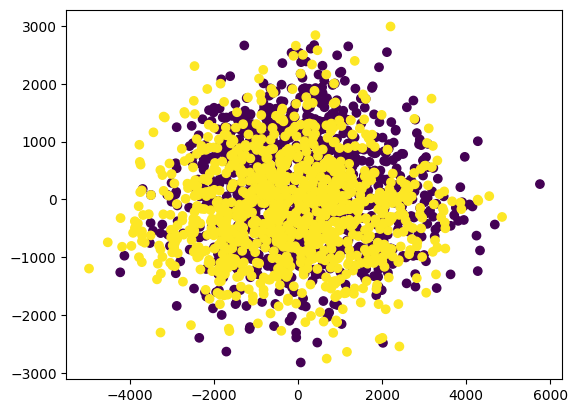

In [4]:
pca = PCA(n_components=2)
zVals = pca.fit_transform(combinedArr)
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
print(f'Total Explained Variance: {sum(pca.explained_variance_ratio_)}')

plt.scatter(zVals[:, 0], zVals[:, 1], c=labels)

### Initial Logistic Regression Model

We train a logistic regression model on all 2304 features to see if a discernable difference can be learned without much preprocessing.

There is severe overfitting, since the train accuracy is 100%, but the test accuracy is 63.75%. This is expected, since we do not have enough datapoints to have such a high number of features.

From looking at the Confusion Matrix, the model does a slightly better job predicting sad faces than predicting happy faces.

Train Accuracy: 1.0
Test Accuracy: 0.6375


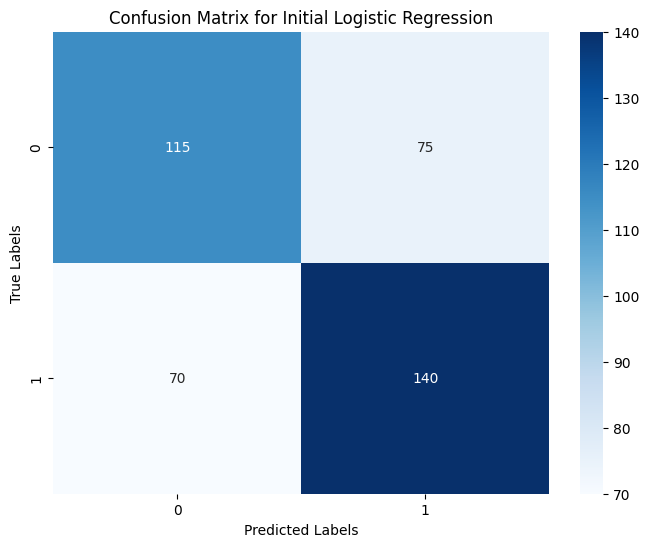

In [5]:
x_train, x_test, y_train, y_test = train_test_split(combinedArr, labels, test_size=0.2, random_state=22)

logReg = LogisticRegression(max_iter=10000)
logReg.fit(x_train, y_train)
print(f"Train Accuracy: {logReg.score(x_train, y_train)}")
print(f"Test Accuracy: {logReg.score(x_test, y_test)}")

cm = confusion_matrix(y_test, logReg.predict(x_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix for Initial Logistic Regression")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Cross Validation to Determine the Optimal Number of Dimensions to Reduce To

We will now reduce the dimensions of the dataset using Principle Component Analysis. We will use 5-fold cross validation to determine the optimal number of dimensions to use in the binary logistic regression model to strike a balance between overfitting and underfitting.


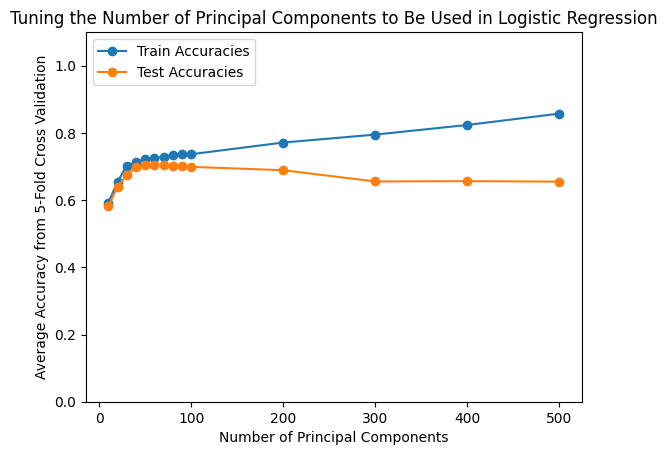

In [12]:
X = combinedArr
y = labels

kfold = KFold(n_splits=5, shuffle=True, random_state=22)

accuracies = {}
for dim in list(range(10, 110, 10)) + list(range(200, 600, 100)):
    pca = PCA(n_components=dim)
    trainAccuracy = []
    testAccuracy = []
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        z_train = pca.fit_transform(X[train_index])
        y_train = labels[train_index]
        z_test = pca.transform(X[test_index])
        y_test = labels[test_index]
        logReg = LogisticRegression(max_iter=10000)
        logReg.fit(z_train, y_train)

        trainAccuracy.append(logReg.score(z_train, y_train))
        testAccuracy.append(logReg.score(z_test, y_test))
    accuracies[dim] = (np.mean(trainAccuracy), np.mean(testAccuracy))

degree = list(accuracies)
trainAccuracies, testAccuracies = zip(*accuracies.values())

plt.plot(degree, trainAccuracies, "-o", label = "Train Accuracies")
plt.plot(degree, testAccuracies, "-o", label = "Test Accuracies")
plt.title("Tuning the Number of Principal Components to Be Used in Logistic Regression")
plt.xlabel("Number of Principal Components")
plt.ylabel("Average Accuracy from 5-Fold Cross Validation")
plt.ylim(0, 1.1)
plt.legend(loc="upper left")
plt.show()

In [16]:
optimal = max([info for info in accuracies.items()], key=lambda x: x[1][1])
print("Optimal Number of Dimensions:\n")
print(f"{optimal[0]} Dimensions")
print(f"Train Accuracy: {optimal[1][0]:.5f}")
print(f"Test Accuracy: {optimal[1][1]:.5f}")

Optimal Number of Dimensions:

70 Dimensions
Train Accuracy: 0.72837
Test Accuracy: 0.70600


### Facial Recognition and Facial Feature Isolation Preprocessing

Since we believe that simply the shape of the mouth of the face can accurately predict whether a person is happy or sad, we will isolate just the mouths of all faces using MTCNN (Multi-Task Cascaded Convolutional Neural Networks), which can pinpoint the location of certain facial features with very high accuracy.

We use MTCNN to create a new array with just the pixels that correspond to a mouth.

In [ ]:
happyArr = np.load('shortened_images/happyArray.npy')
sadArr = np.load('shortened_images/sadArray.npy')

lengthOfHappy = happyArr.shape[0]
lengthOfSad = sadArr.shape[0]

combinedArr = np.concatenate([happyArr, sadArr], axis = 0)

faceDetector = MTCNN()

In [ ]:
mouths = []
labels = []
faceDetector = MTCNN()
length = combinedArr.shape[0]
for index, picture in enumerate(combinedArr):
    if index % 10 == 0: print(f'Image {index} out of {length}')
    face = np.stack((picture,) * 3, axis=-1)
    faces = faceDetector.detect_faces(face)
    if len(faces) >= 1:
        mouth_left = faces[0]["keypoints"]["mouth_left"]
        mouthHorizSize = faces[0]["keypoints"]["mouth_right"][0] - faces[0]["keypoints"]["mouth_left"][0]
        face = face[mouth_left[1] - 5 : mouth_left[1] + 5, mouth_left[0] - 2 : mouth_left[0] + 18][np.newaxis, :, :]
        mouths.append(face)
        labels.append(0 if index < 1000 else 1)
# Remove odd shapes
shape = mouths[0].shape
new_mouths = []
new_labels = []
for index, mouth in enumerate(mouths):
    if shape == mouth.shape:
        new_mouths.append(mouth)
        new_labels.append(labels[index])
new_mouths = np.concatenate(new_mouths, axis = 0)
np.save('shortened_images/mouths.npy', new_mouths)
np.save('shortened_images/mouth_labels.npy', np.array(new_labels))

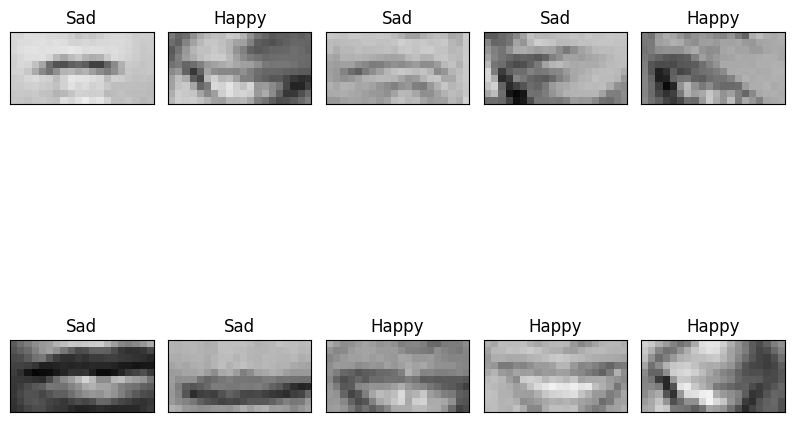

In [ ]:
mouths = np.load('shortened_images/mouths.npy')
mouth_labels = np.load('shortened_images/mouth_labels.npy')

np.random.seed(1)
random_index = np.random.choice(mouths.shape[0], 10)

fig, axs = plt.subplots(2, 5, figsize=(10, 8))
plt.subplots_adjust(wspace=0.1, hspace=0.0)
for i in range(2):
    for j in range(5):
        index = random_index[i * 5 + j]
        axs[i, j].imshow(mouths[index])
        axs[i, j].title.set_text("Happy" if mouth_labels[index] == 0 else "Sad")
        axs[i, j].tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False,
                   labelbottom=False, labelleft=False)

Now, we perform PCA again to attempt to plot the differences between happy and sad faces.

While there still is no obvious difference, you can see that the happy faces (purple) are a bit more to the left and the sad faces (yellow) are a bit more to the right. This is a small improvement from using the whole face.

Explained Variance Ratio: [0.46207603 0.11718947]
Total Explained Variance: 0.579265502425967


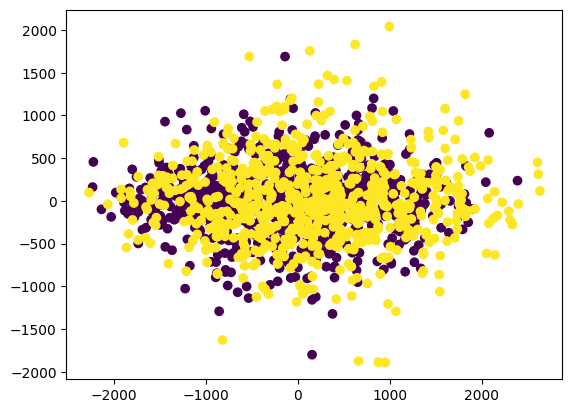

In [ ]:
pca = PCA(n_components=2)
zVals = pca.fit_transform(mouths.reshape(mouths.shape[0], -1))
print(f'Explained Variance Ratio: {pca.explained_variance_ratio_}')
print(f'Total Explained Variance: {sum(pca.explained_variance_ratio_)}')

plt.scatter(zVals[:, 0], zVals[:, 1], c=mouth_labels)

### Improved Logistic Regression Model

Now when we train a logistic regression model with only the mouths, the train accuracy drops to 79.84%, and the test accuracy improves to 72.99%. There is much less overfitting and an overall improvement in prediction accuracy.

From looking at the Confusion Matrix, the model does a better job than the initial Logistic Regression model, and a similar job predicting between happy and sad mouths.

Train Accuracy: 0.7983870967741935
Test Accuracy: 0.729903536977492


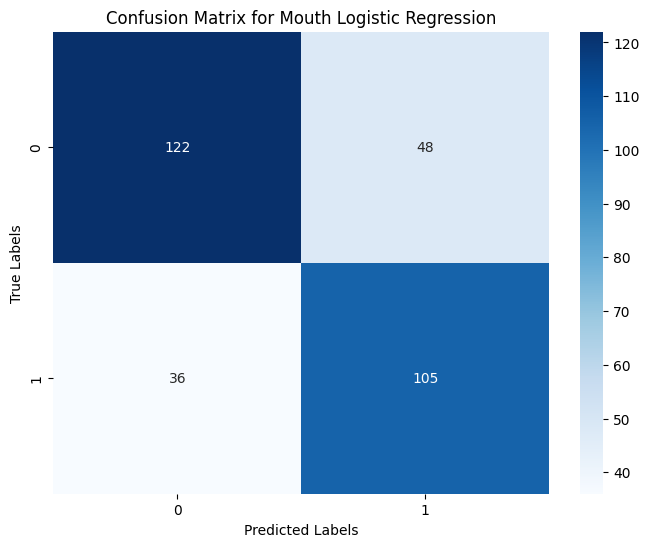

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(mouths.reshape(mouths.shape[0], -1), mouth_labels,
                                                    test_size=0.2, random_state=22)

logReg = LogisticRegression(max_iter=10000)
logReg.fit(x_train, y_train)
print(f"Train Accuracy: {logReg.score(x_train, y_train)}")
print(f"Test Accuracy: {logReg.score(x_test, y_test)}")

cm = confusion_matrix(y_test, logReg.predict(x_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix for Mouth Logistic Regression")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Support Vector Machine

We will now train a support vector machine with various kernels to predict the emotion (happy or sad) from only the mouths. We will use 5-fold cross validation to tune the degree hyperparameter of the polynomial kernel to select the best SVM model to use.

#### SVM with a Polynomial (Degree = 1) Kernel

With a degree 1 polynomial kernel, both the train and test accuracy are around 77%, so the model performs relatively well without overfitting. From the confusion matrix, the model does a slightly better job predicting happy faces over sad faces.

Train Accuracy: 0.7701612903225806
Test Accuracy: 0.7717041800643086


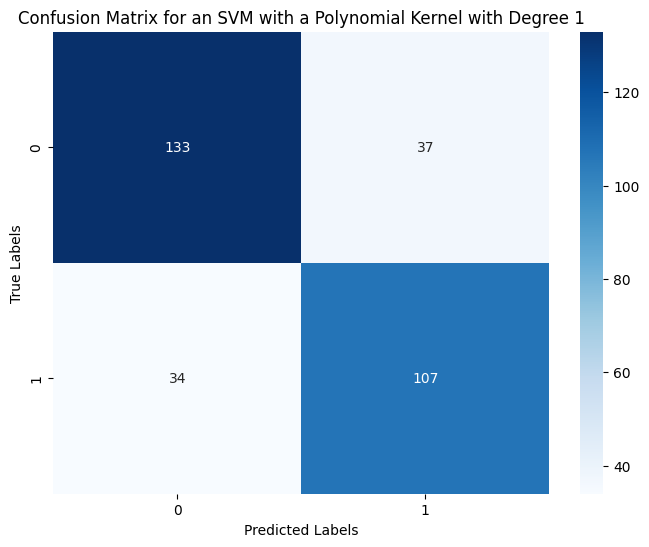

In [ ]:
svm = SVC(kernel = "poly", degree = 1)

svm.fit(x_train, y_train)
print(f"Train Accuracy: {svm.score(x_train, y_train)}")
print(f"Test Accuracy: {svm.score(x_test, y_test)}")

cm = confusion_matrix(y_test, svm.predict(x_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix for an SVM with a Polynomial Kernel with Degree 1")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()



### SVM with a Radial Basis Function (RBF) Kernel

With a RBF kernel, the train accuracy increases to 87%, but the test accuracy remains near 77%. Thus, without increased performance, the RBF kernel slightly overfits the data.

Train Accuracy: 0.8685483870967742
Test Accuracy: 0.77491961414791


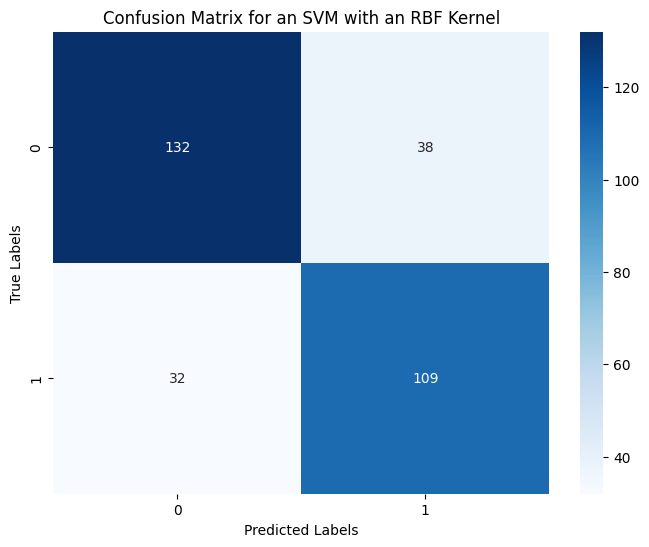

In [ ]:
svm = SVC(kernel = "rbf")
svm.fit(x_train, y_train)
print(f"Train Accuracy: {svm.score(x_train, y_train)}")
print(f"Test Accuracy: {svm.score(x_test, y_test)}")  # Accuracy is now 72.99%

cm = confusion_matrix(y_test, svm.predict(x_test))
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.title("Confusion Matrix for an SVM with an RBF Kernel")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

#### Cross Validation

We will now perform 5-fold cross validation to select the best polynomial kernel to use for an SVM model.

From our analysis, the best performing polynomial kernel has degree 1, since all other polynomial kernels have lower average test accuracies. In addition, the polynomial kernel with degree 1 is the only kernel that does not overfit the data: as the degree increases, the train accuracy increases tremendously, but the test accuracy slightly decreases.

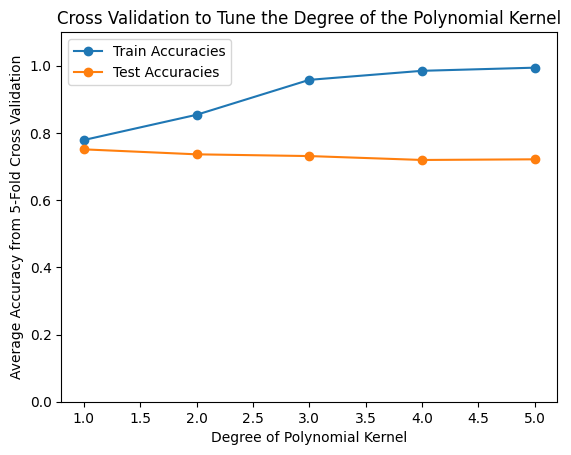

In [ ]:
# Cross Validation

X = mouths.reshape(mouths.shape[0], -1)
y = mouth_labels

kfold = KFold(n_splits=5, shuffle=True, random_state=22)

accuracies = {}
for degree in range(1, 6):
    svm = SVC(kernel = "poly", degree = degree)
    trainAccuracy = []
    testAccuracy = []
    for i, (train_index, test_index) in enumerate(kfold.split(X)):
        svm.fit(X[train_index], y[train_index])
        trainAccuracy.append(svm.score(X[train_index], y[train_index]))
        testAccuracy.append(svm.score(X[test_index], y[test_index]))
    accuracies[degree] = (np.mean(trainAccuracy), np.mean(testAccuracy))

degree = list(accuracies)
trainAccuracies, testAccuracies = zip(*accuracies.values())

plt.plot(degree, trainAccuracies, "-o", label = "Train Accuracies")
plt.plot(degree, testAccuracies, "-o", label = "Test Accuracies")
plt.title("Cross Validation to Tune the Degree of the Polynomial Kernel")
plt.xlabel("Degree of Polynomial Kernel")
plt.ylabel("Average Accuracy from 5-Fold Cross Validation")
plt.ylim(0, 1.1)
plt.legend(loc="upper left")
plt.show()